In [1]:
# For Data Handling and Preprocessing
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scprep

# For Batch Correction
import harmonypy as hm

# For Clustering
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn import metrics

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

2023-04-27 18:25:46.545226: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 18:25:46.596439: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 18:25:46.597607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 18:25:47.480499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Read Data

In [13]:
#set paths
path_cwd=os.getcwd()
path_train_data = path_cwd + '/ML4G_Project_2_Data/train_data'
path_test_data = path_cwd + '/ML4G_Project_2_Data/test_data'

#train_data
bulk_train = pd.read_csv(path_train_data +'/pancreas_bulk_train.csv',index_col=0)
metadata_train = pd.read_csv(path_train_data+ '/pancreas_sc_metadata_train.csv', index_col=0)
sc_train_raw = pd.read_csv(path_train_data +'/pancreas_sc_train.csv', 
                       index_col=0, header=0)

#test_data
metadata_test = pd.read_csv(path_test_data+ '/pancreas_sc_metadata_test_wocelltype.csv', index_col=0)
sc_test_raw = pd.read_csv(path_test_data +'/pancreas_sc_test.csv', 
                        index_col=0, header=0)

## 2. Preprocess Data

In [19]:
#create preprocessing function
def preprocess(adata, 
               filter_genes=True,
               min_counts=10, 
               min_cells=300,
               normalize1=True,
               key_n_counts='n_counts_all', 
               normalize_scprep=False,
               sq_transform=True,
               log_transform=False, 
               filter_highly_variable=True,
               n_top_genes=200, 
               harmony=True, 
               harmony_vars = ["Sample", "Disease"],
               harmony_max_iter=20,
               verbose=False,
               normalize2=True,
               scaling=True):
    """
    Preprocesses the data using scanpy functions and harmony if specified.
    """

    #filter genes based on counts and normalize
    if filter_genes:
        sc.pp.filter_genes(adata, min_counts=min_counts)
        sc.pp.filter_genes(adata, min_cells=min_cells)

    # Normalize library sizes
    if normalize1:
        sc.pp.normalize_per_cell(adata, key_n_counts=key_n_counts)

    if normalize_scprep==True:
        adata.X = scprep.normalize.library_size_normalize(adata.X)
        
    # Transform sqrt
    if sq_transform==True:
        adata.X = scprep.transform.sqrt(adata.X)    

    #log transform data
    if log_transform: 
        sc.pp.log1p(adata)

    if filter_highly_variable:
        sc.pp.highly_variable_genes(adata, 
                                    flavor='cell_ranger', 
                                    n_top_genes=n_top_genes,
                                    inplace=True,
                                    subset=True)

    #run batch correction
    if harmony:
        print("Running Harmony:")
        ho = hm.run_harmony(adata.X, 
                            adata.obs, 
                            harmony_vars, 
                            max_iter_harmony=harmony_max_iter,
                            verbose=verbose)

        # Format output
        adata.X = ho.Z_corr.T

    
    #renormalize after filtering
    if normalize2:
        sc.pp.normalize_per_cell(adata) 

    #scaling
    if scaling:
        sc.pp.scale(adata)
    
    return adata

In [20]:
#Apply preprocessing to train set
sc_train = sc.AnnData(sc_train_raw.T, obs=metadata_train)
sc_train.obs_names = sc_train_raw.columns
sc_train_pp = preprocess(sc_train.copy())
sc_train_pp_noharmony = preprocess(sc_train, harmony=False)

#Apply preprocessing to test set
sc_test = sc.AnnData(sc_test_raw.T, obs=metadata_test)
sc_test.obs_names = sc_test_raw.columns
sc_test_pp = preprocess(sc_test.copy())
sc_test_pp_noharmony = preprocess(sc_test, harmony=False)

2023-04-27 18:36:39,089 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony:


2023-04-27 18:36:39,553 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-27 18:36:42,326 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony:


2023-04-27 18:36:42,673 - harmonypy - INFO - sklearn.KMeans initialization complete.


## 3. Check Embedding

/home/mike/anaconda3/envs/eth_ml4g/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


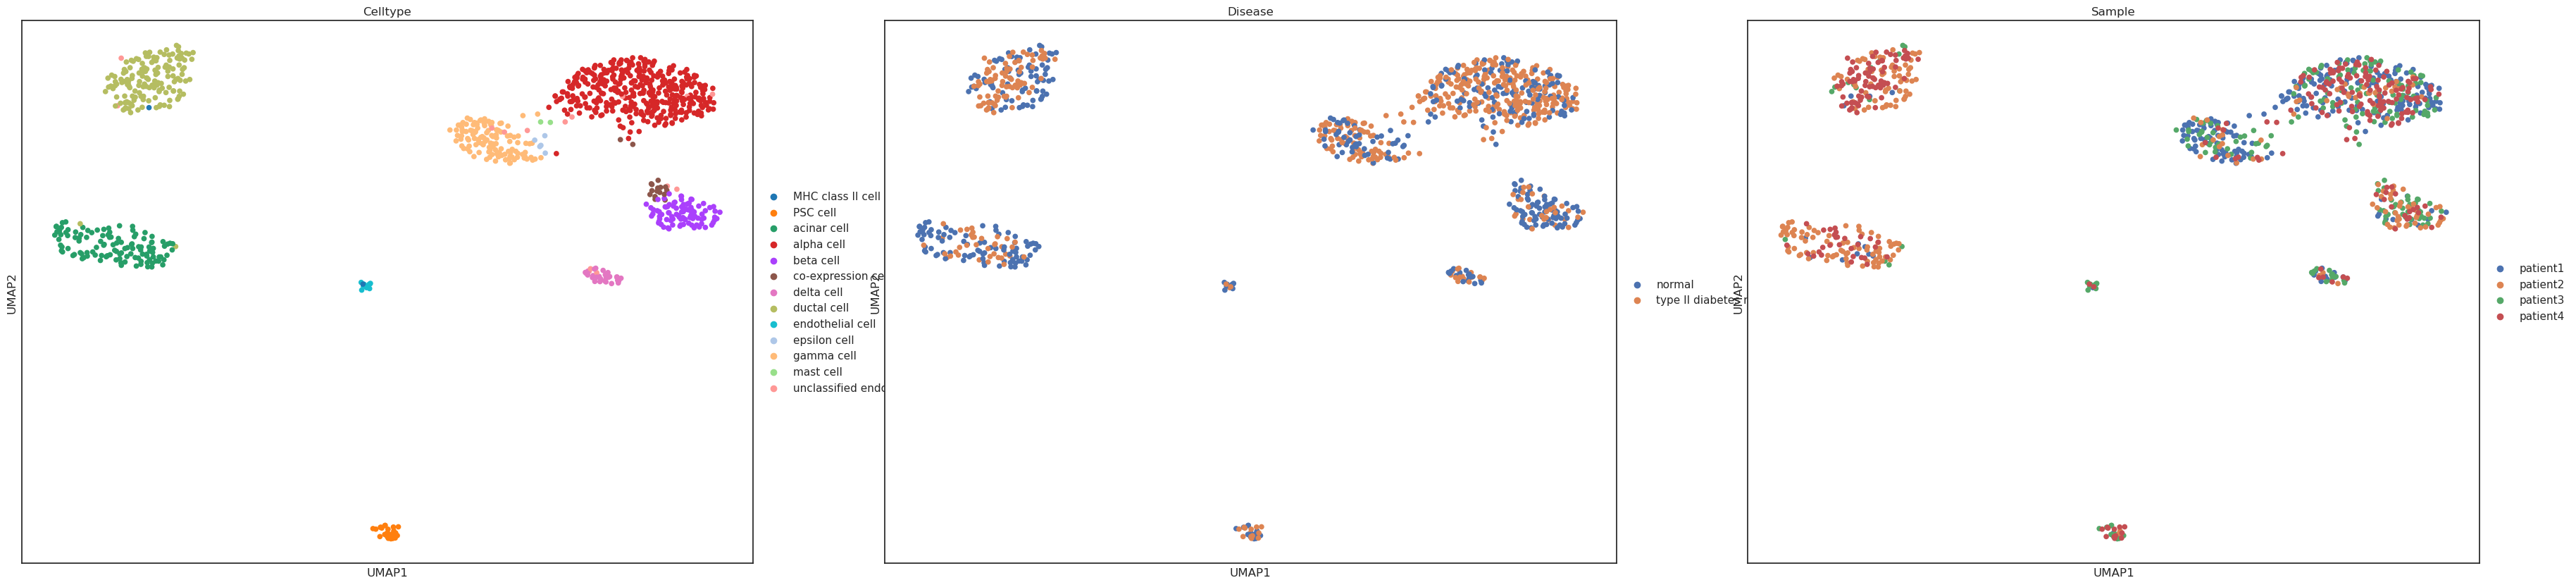

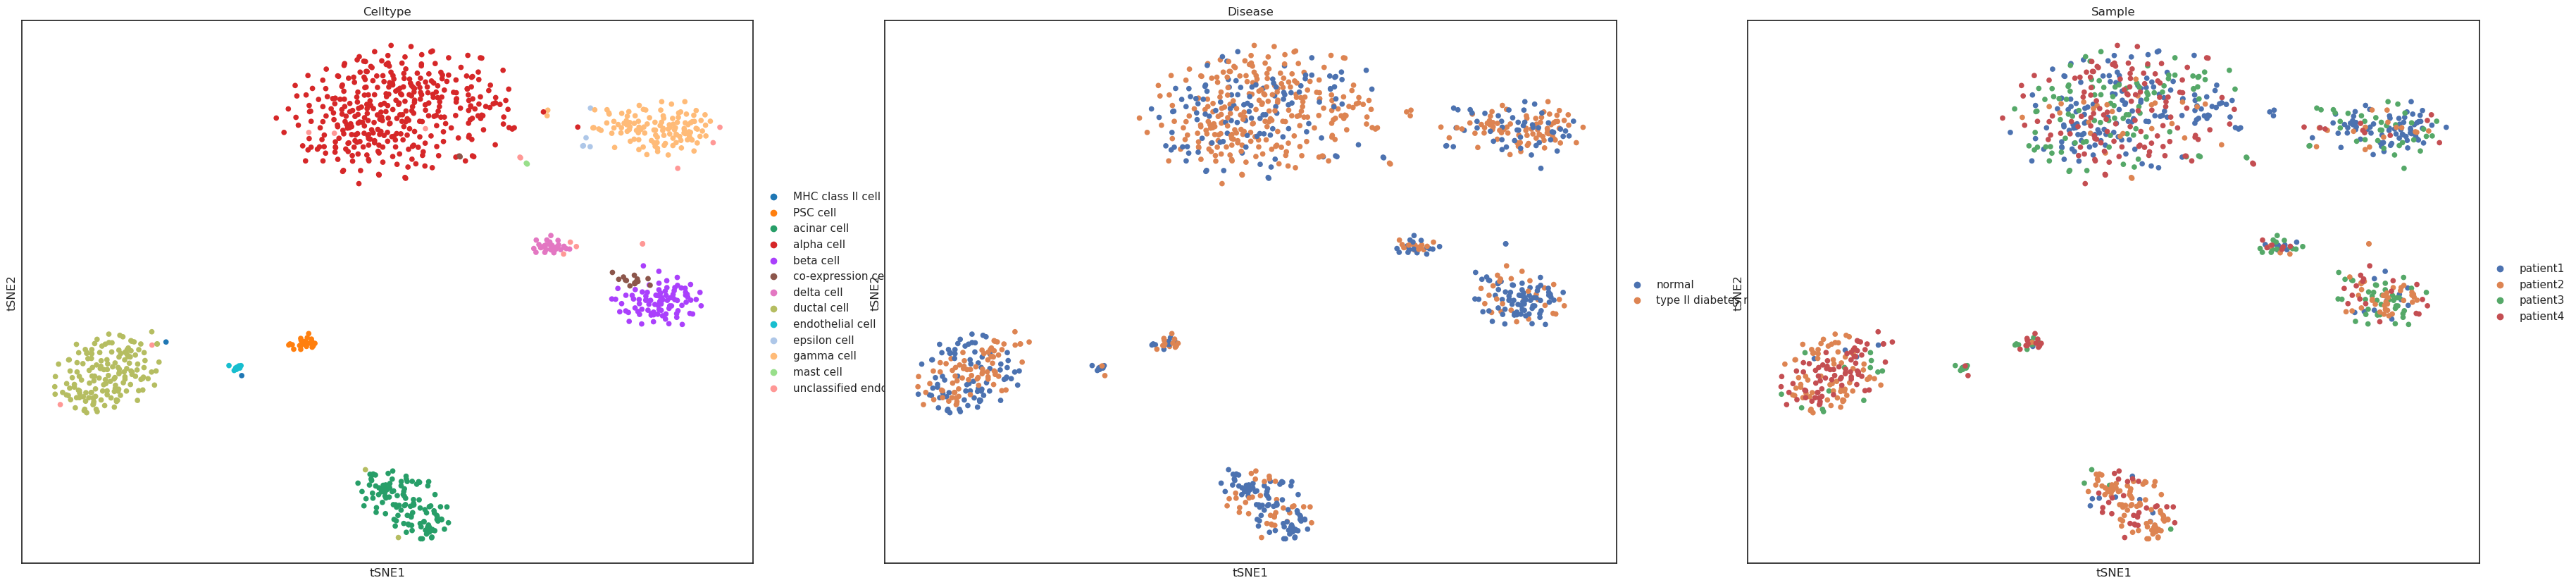

In [27]:
#Embeddings for training data with batch correction via harmony
sc.pp.neighbors(sc_train_pp, n_neighbors=10, method='umap', use_rep='X')
sc.tl.umap(sc_train_pp)
sc.tl.tsne(sc_train_pp, use_rep='X')
sc.pl.umap(sc_train_pp, color=["Celltype", "Disease", "Sample"])
sc.pl.tsne(sc_train_pp, color=["Celltype", "Disease", "Sample"])

/home/mike/anaconda3/envs/eth_ml4g/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


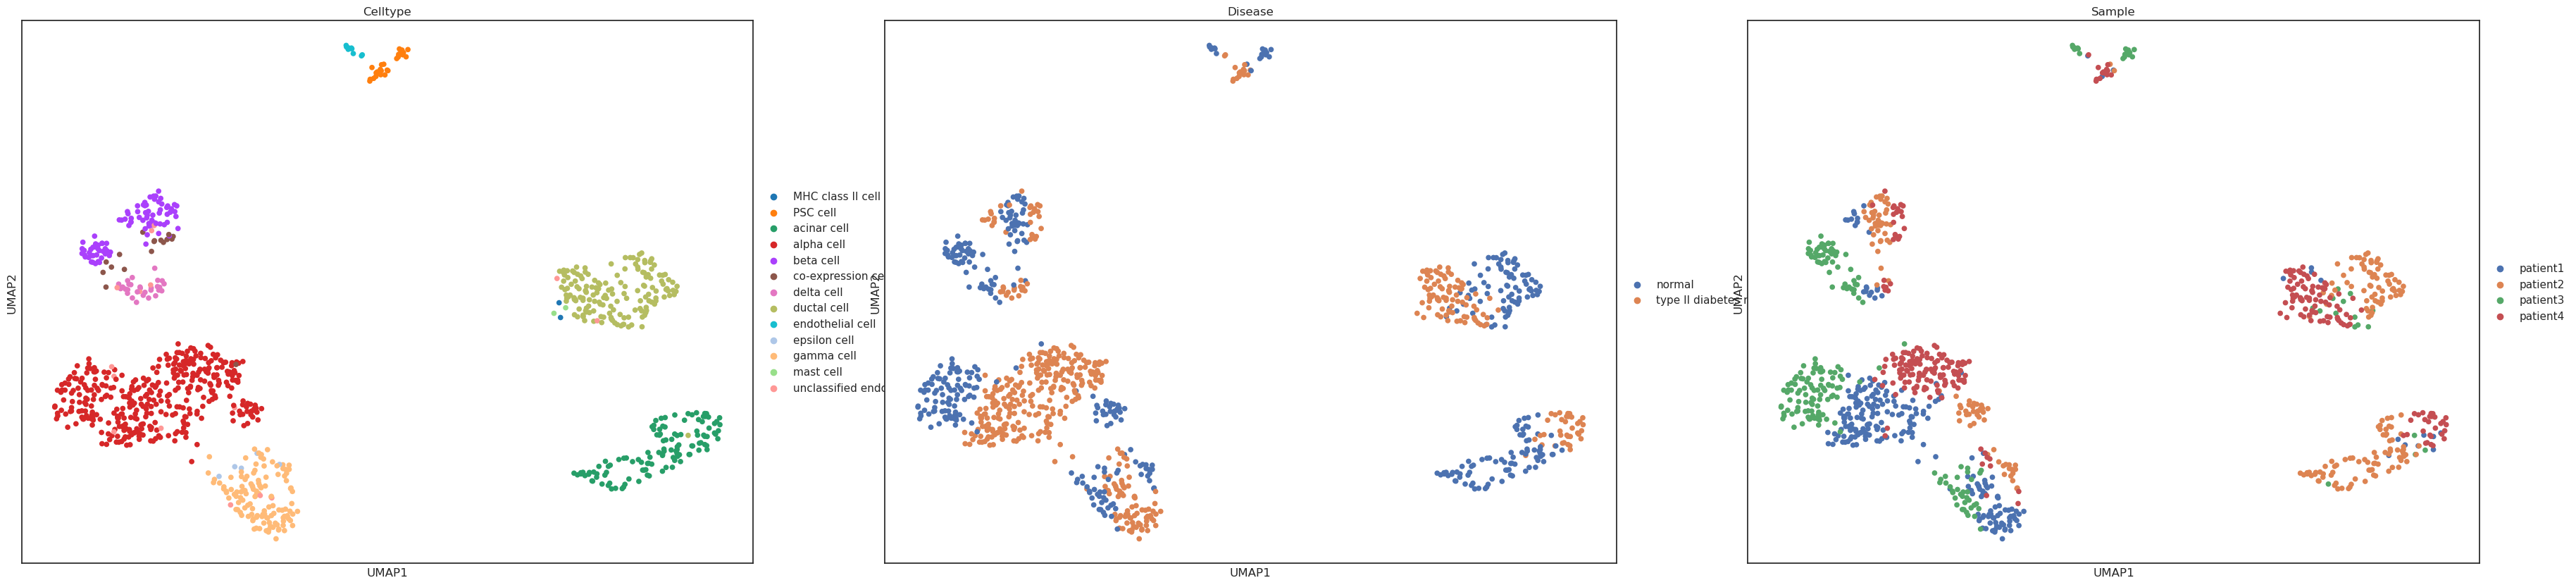

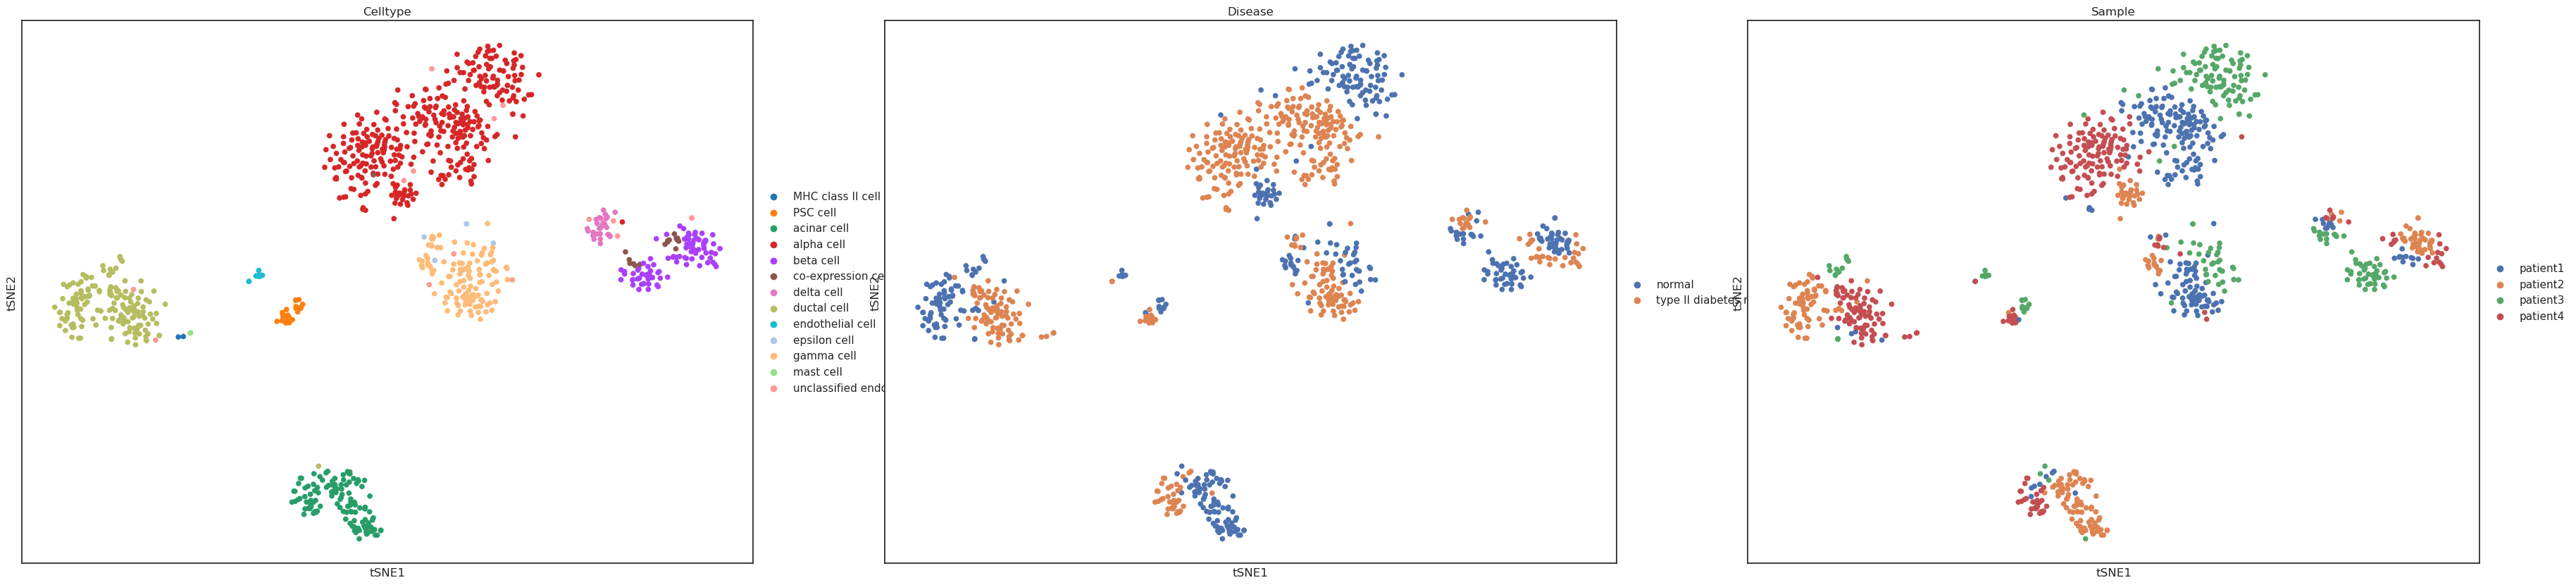

In [29]:
#Embeddings for training data without batch correction via harmony
sc.pp.neighbors(sc_train_pp_noharmony, n_neighbors=10, method='umap', use_rep='X')
sc.tl.umap(sc_train_pp_noharmony)
sc.tl.tsne(sc_train_pp_noharmony, use_rep='X')
sc.pl.umap(sc_train_pp_noharmony, color=["Celltype", "Disease", "Sample"])
sc.pl.tsne(sc_train_pp_noharmony, color=["Celltype", "Disease", "Sample"])

/home/mike/anaconda3/envs/eth_ml4g/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


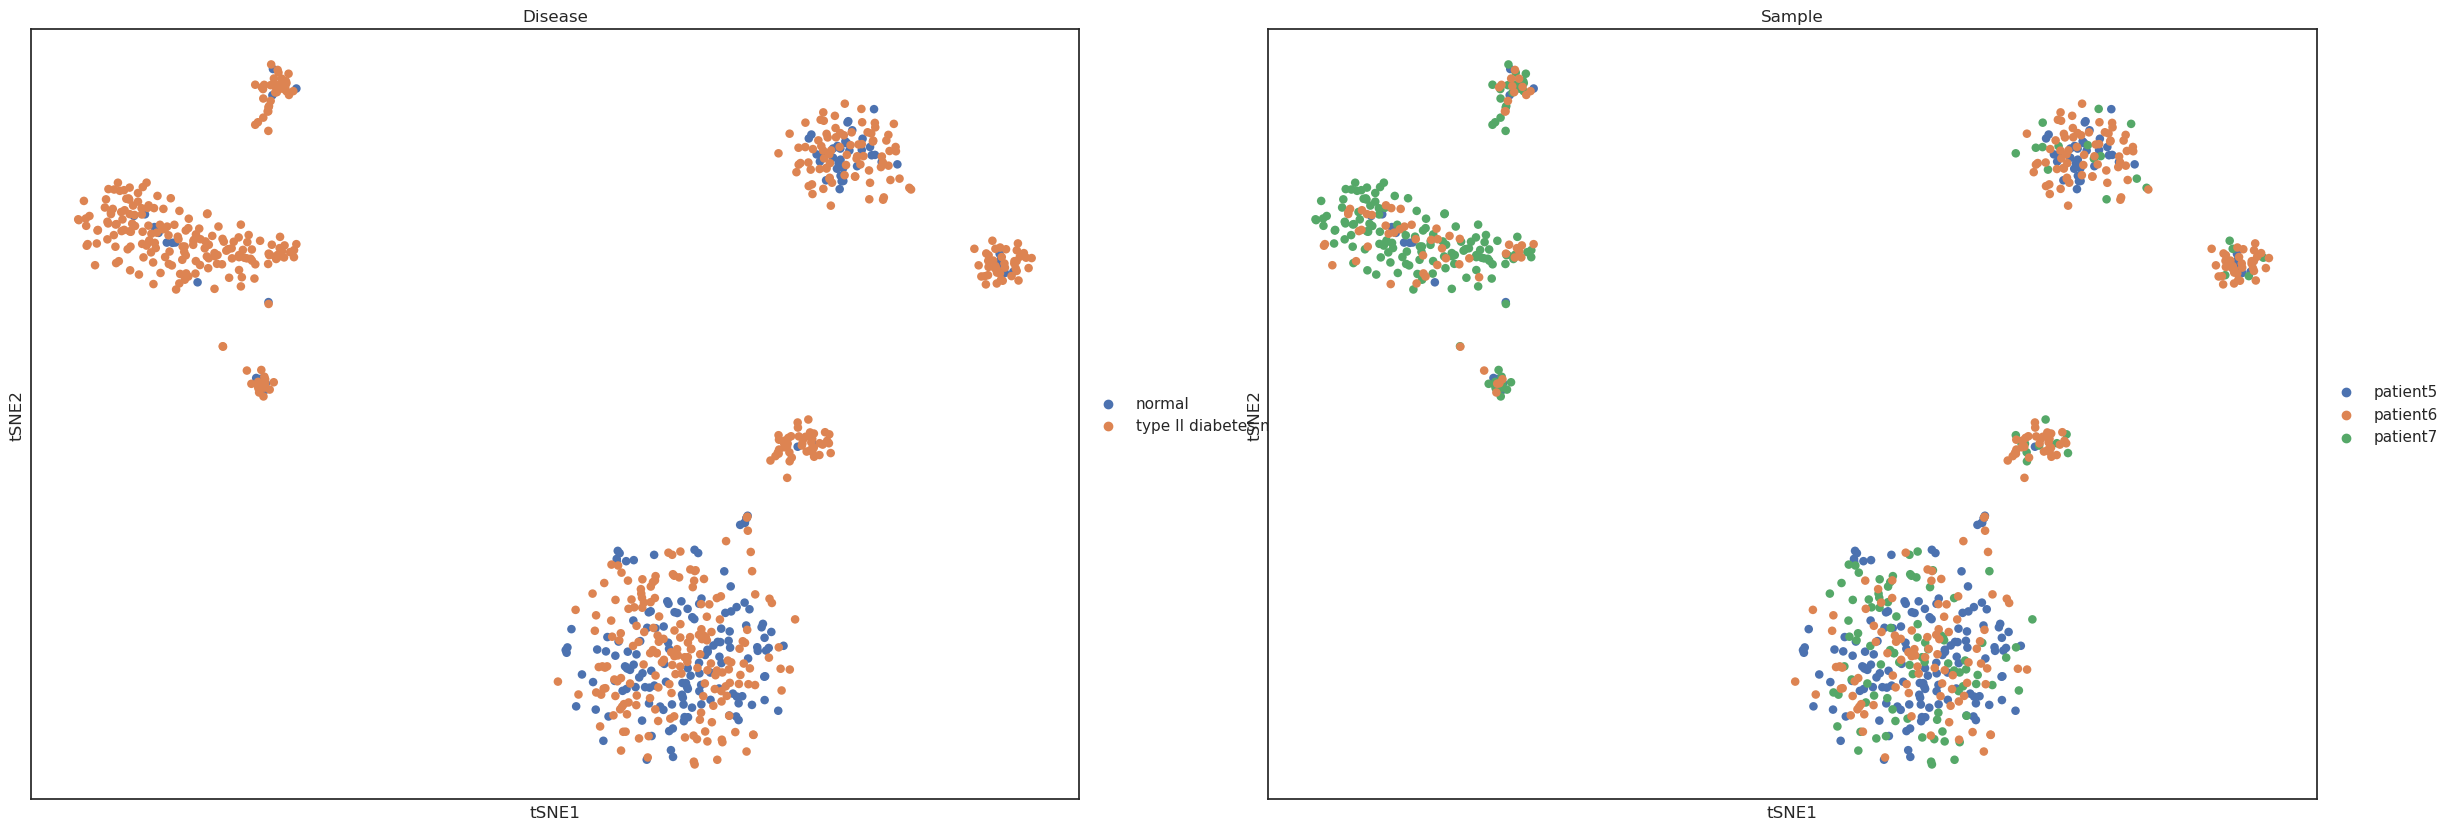

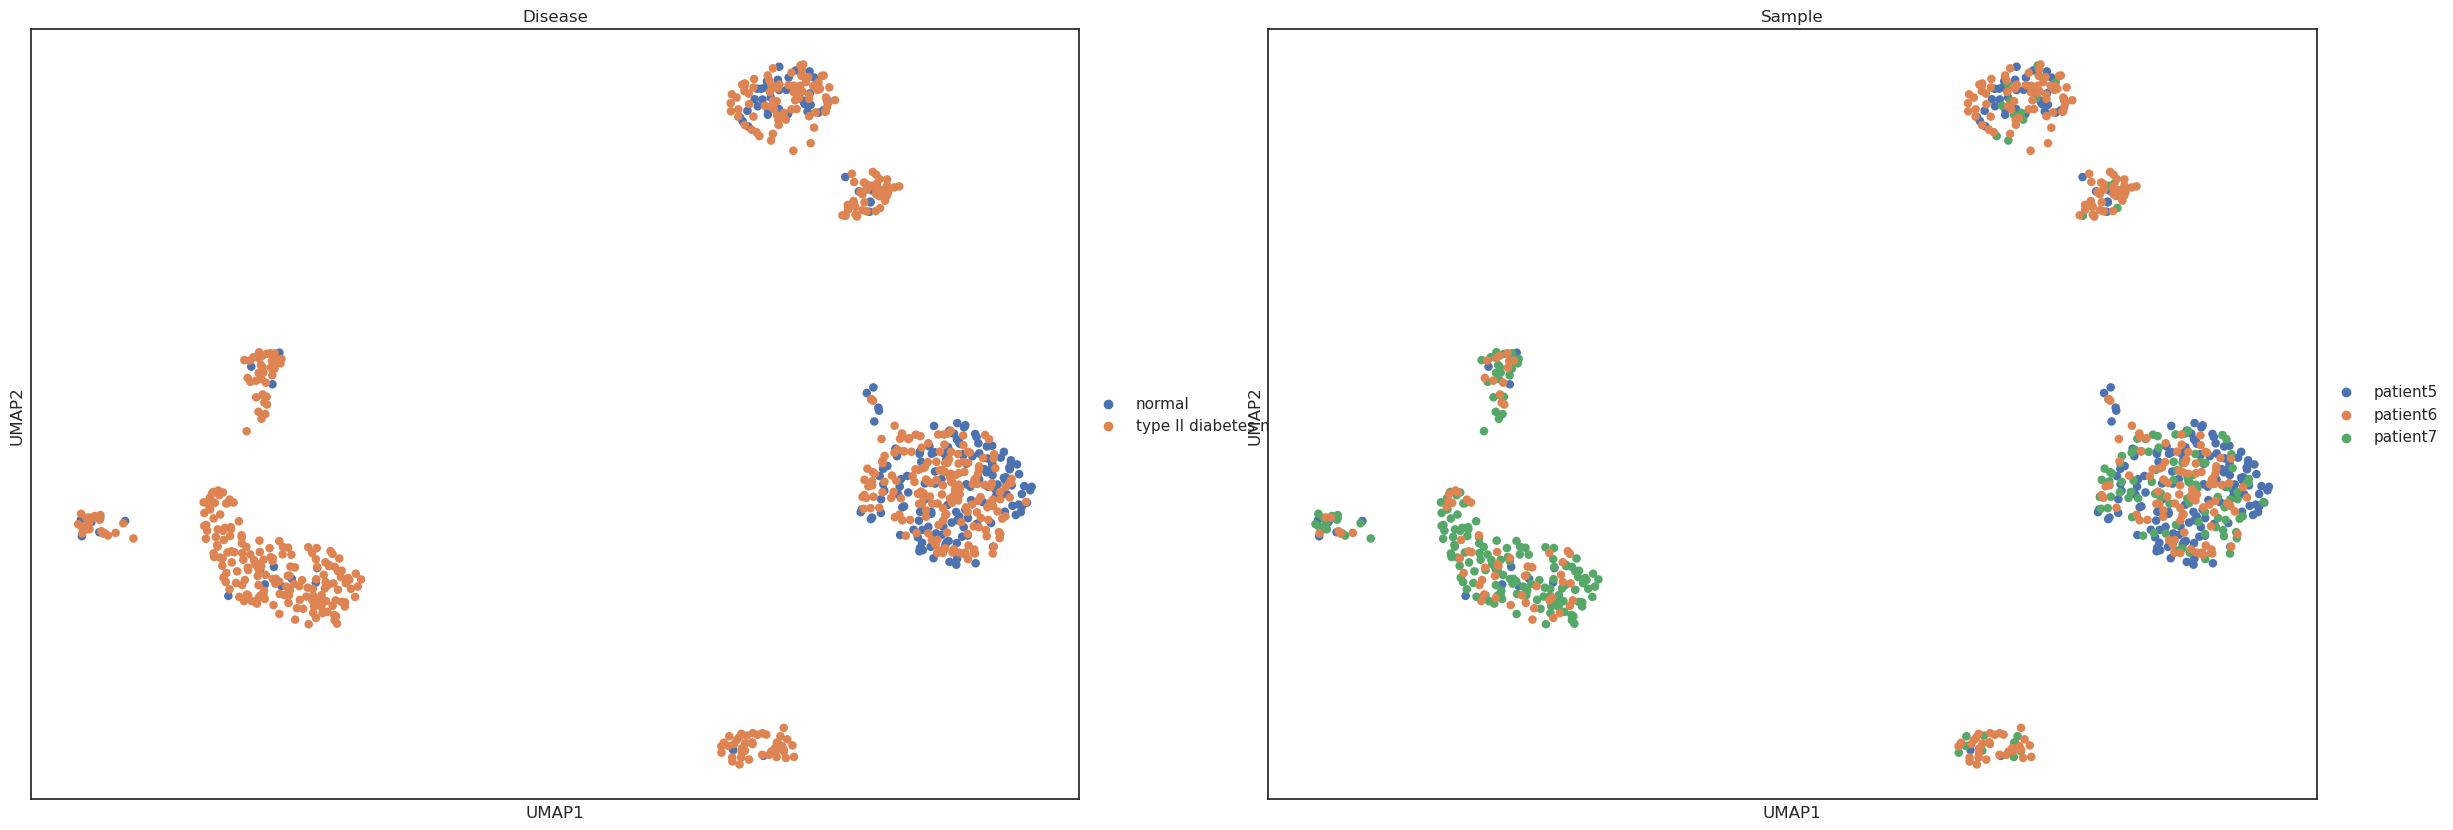

In [32]:
#Embeddings for testing data with batch correction via harmony
sc.pp.neighbors(sc_test_pp, n_neighbors=20, method='umap')
sc.tl.umap(sc_test_pp)
sc.tl.tsne(sc_test_pp, use_rep='X')
sc.pl.tsne(sc_test_pp, color=["Disease", "Sample"])
sc.pl.umap(sc_test_pp, color=["Disease", "Sample"])

/home/mike/anaconda3/envs/eth_ml4g/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


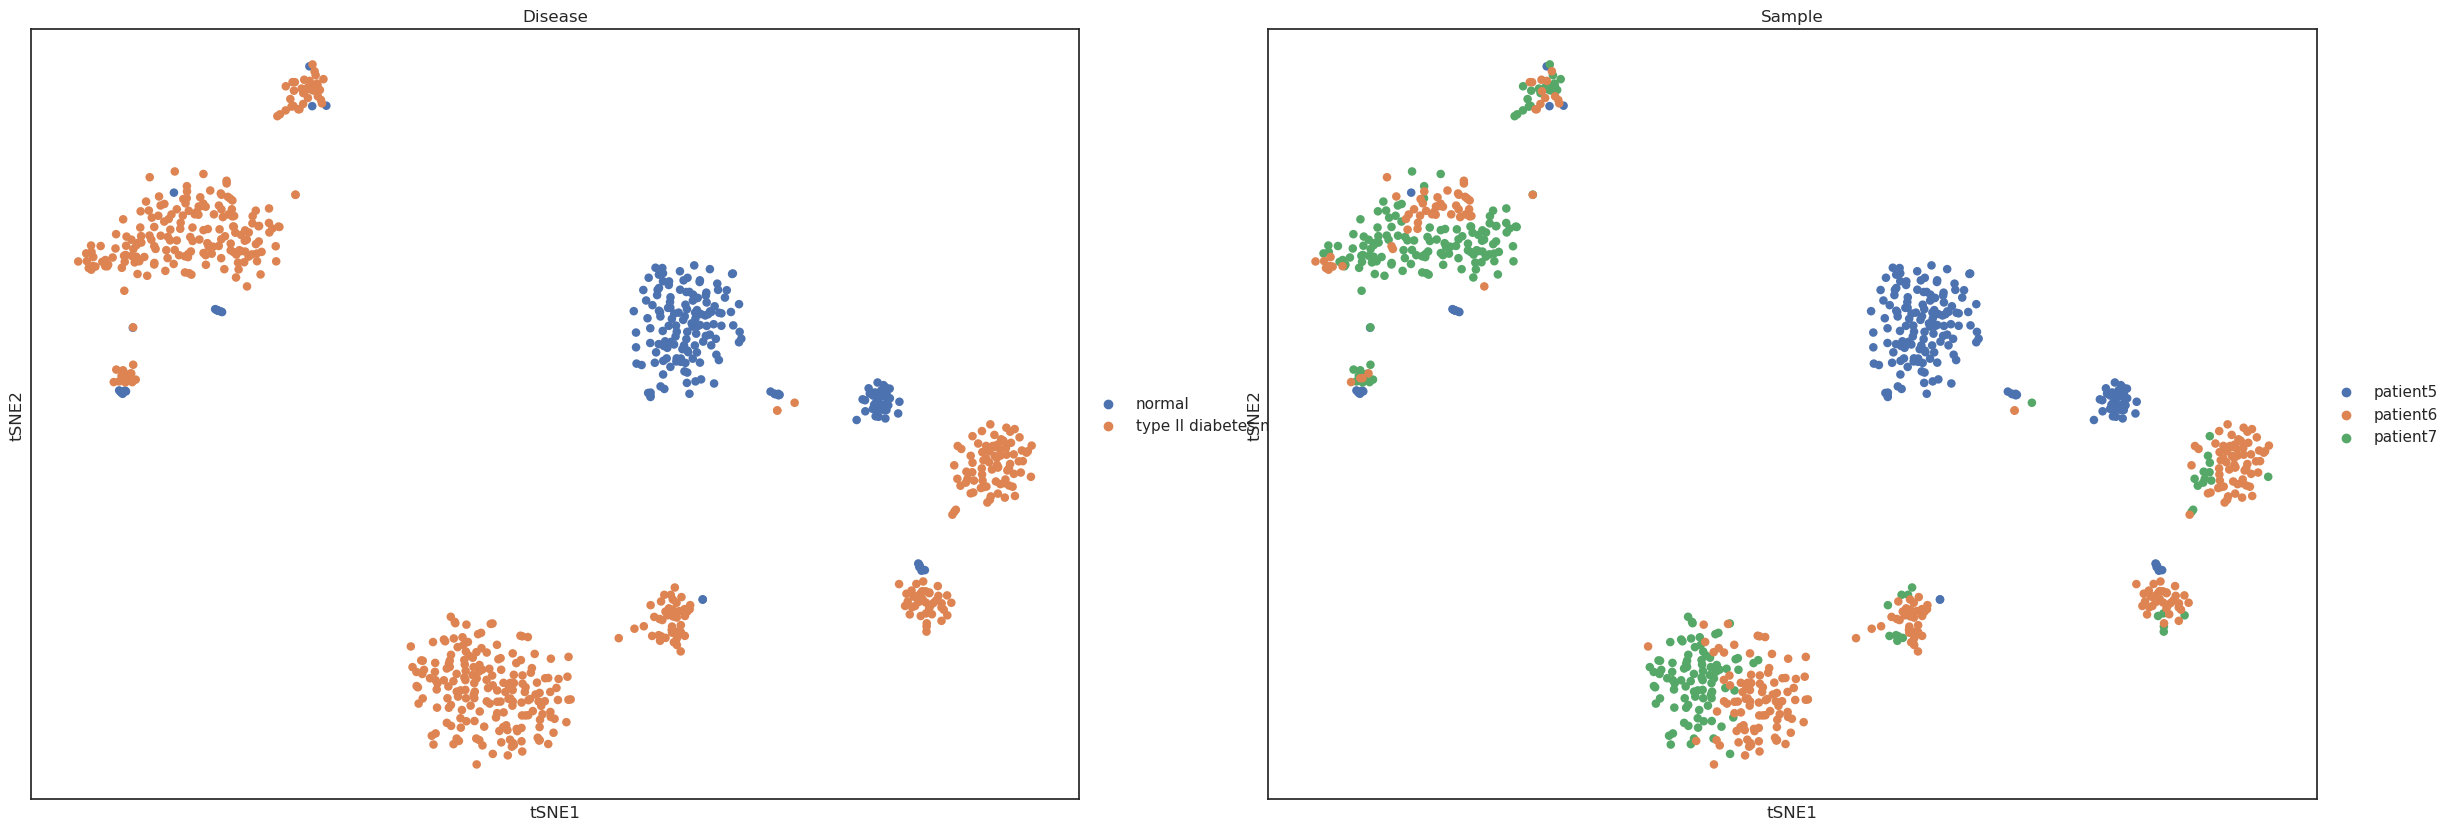

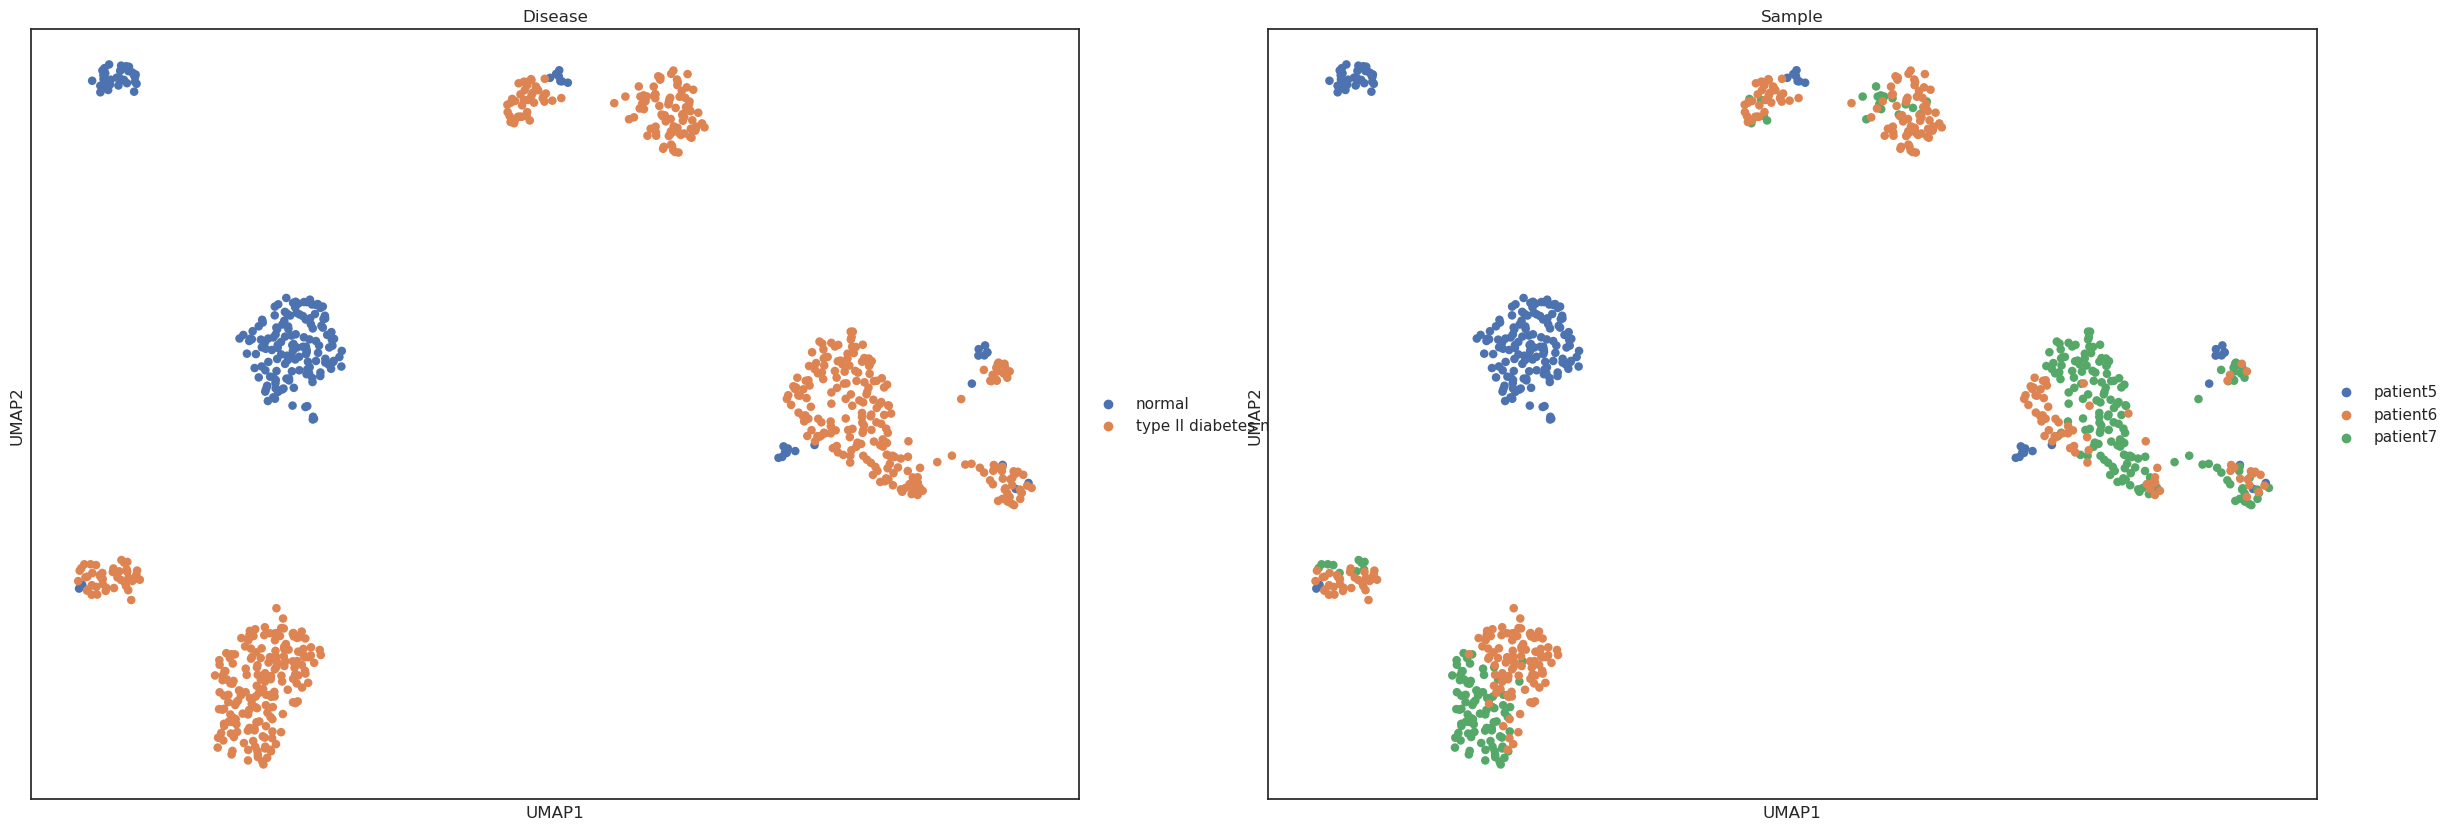

In [31]:
#Embeddings for testing data without batch correction via harmony
sc.pp.neighbors(sc_test_pp_noharmony, n_neighbors=20, method='umap')
sc.tl.umap(sc_test_pp_noharmony)
sc.tl.tsne(sc_test_pp_noharmony, use_rep='X')
sc.pl.tsne(sc_test_pp_noharmony, color=["Disease", "Sample"])
sc.pl.umap(sc_test_pp_noharmony, color=["Disease", "Sample"])

## 4. Perform Clustering

In [33]:
#Functions for clustering
def print_scores(pca_matrix, labels, labels_true):
    """
    Print various scores
    """
    v_score = metrics.v_measure_score(labels_true, labels)
    ari_score = metrics.adjusted_rand_score(labels_true, labels)
    silhouette_score = metrics.silhouette_score(pca_matrix, labels)

    print(f"V-measure: {v_score:.3f}")
    print(f"Adjusted Rand Index: {ari_score:.3f}")
    print(f"Silhouette Coefficient: {silhouette_score:.3f}")
    print(f"Overall Clustering Score: {1/3*(v_score+ari_score+silhouette_score)}")

def get_clustering_score(pca_matrix, labels, labels_true):
    """
    Return clustering score
    """
    v_score = metrics.v_measure_score(labels_true, labels)
    ari_score = metrics.adjusted_rand_score(labels_true, labels)
    silhouette_score = metrics.silhouette_score(pca_matrix, labels)

    return 1/3*(v_score+ari_score+silhouette_score)

def get_silhouette_score(pca_matrix, labels):
    return metrics.silhouette_score(pca_matrix, labels)


In [41]:
    
def apply_louvain(adata,
                  pca_path, 
                  cluster_path,
                  n_neighbors = 20, 
                  n_components_umap = 100,
                  resolution = 0.75,
                  plot = True, 
                  print_score = True, 
                  test = False,
                  store_pca_ = True,
                  store_clustering = True):
    
    #Compute neighbor graph
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, method='umap', use_rep='X')

    if plot:
        sc.tl.umap(adata)

    #Get PCA for silhouette score
    lowd_umap = umap.UMAP(random_state=42, n_components = n_components_umap).fit_transform(adata.X)
    pca = PCA(n_components=50).fit_transform(lowd_umap)

    #Find communities
    sc.tl.leiden(adata, resolution=resolution)

    #Extract results
    labels = adata.obs['leiden'].to_list()
    if not test:
        labels_true = adata.obs['Celltype'].to_list()

    #Print scores
    if print_score and not test:
        print_scores(pca, labels, labels_true)
    if print_score and test:
        print("Silhouette Score: " + str(get_silhouette_score(pca, labels)))

    #Plot results
    if plot and not test:
        sc.pl.umap(adata, color=["Celltype", "leiden"])
        sc.pl.umap(adata, color=["Disease", "Sample"])
    if plot and test:
        sc.pl.umap(adata, color=["leiden", "Disease", "Sample"])

    #Store results if wished
    if store_pca_:
        pca_df = pd.DataFrame(pca, columns=["PC"+str(i) for i in range(1,51)])
        pca_df.insert(0, "index", adata.obs_names)
        pca_df.to_csv(pca_path, index=True)

    if store_clustering:
        cluster_df = pd.DataFrame(labels, columns=["cluster"])
        cluster_df.insert(0, "index", adata.obs_names)
        cluster_df.to_csv(cluster_path, index=True)


# def apply_kmeans(data, labels_true, n_clusters, plot = True, print_score = True, test = False):
#     lowd_data_c = umap.UMAP(random_state=42, n_components = 200).fit_transform(data)
#     lowd_data = PCA(n_components=50).fit_transform(lowd_data_c)

#     KMean= KMeans(n_clusters=n_clusters, max_iter=500)
#     KMean.fit(lowd_data_c)
#     labels = KMean.predict(lowd_data_c)

#     if print_score and not test:
#         print_scores(lowd_data, labels, metadata_train["Celltype"])

#     if plot:
#         standard_embedding = umap.UMAP(random_state=42).fit_transform(data)
#         plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels, s=0.5, cmap='Spectral');

#     if test == True:
#         return get_silhouette_score(lowd_data, labels)
    
#     else:
#         return get_clustering_score(lowd_data, labels, labels_true)

V-measure: 0.923
Adjusted Rand Index: 0.953
Silhouette Coefficient: 0.869
Overall Clustering Score: 0.9150795986383948


/home/mike/anaconda3/envs/eth_ml4g/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


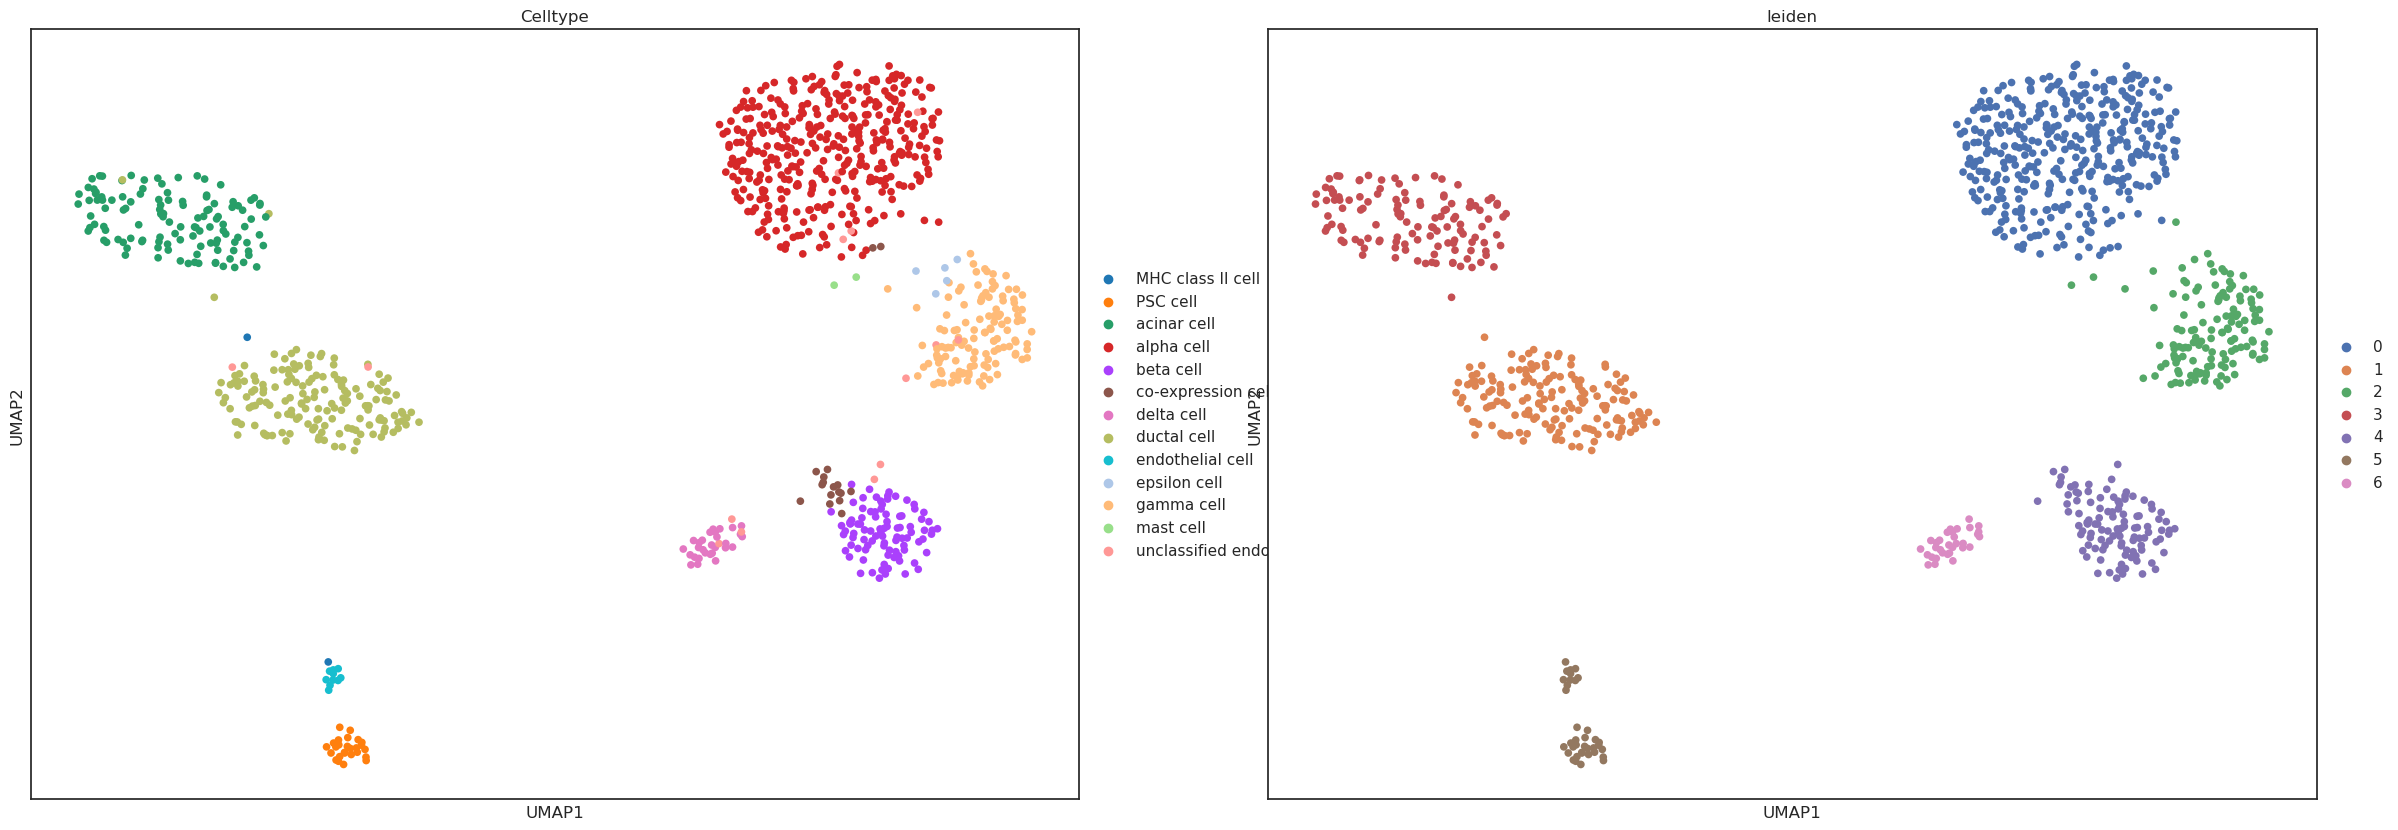

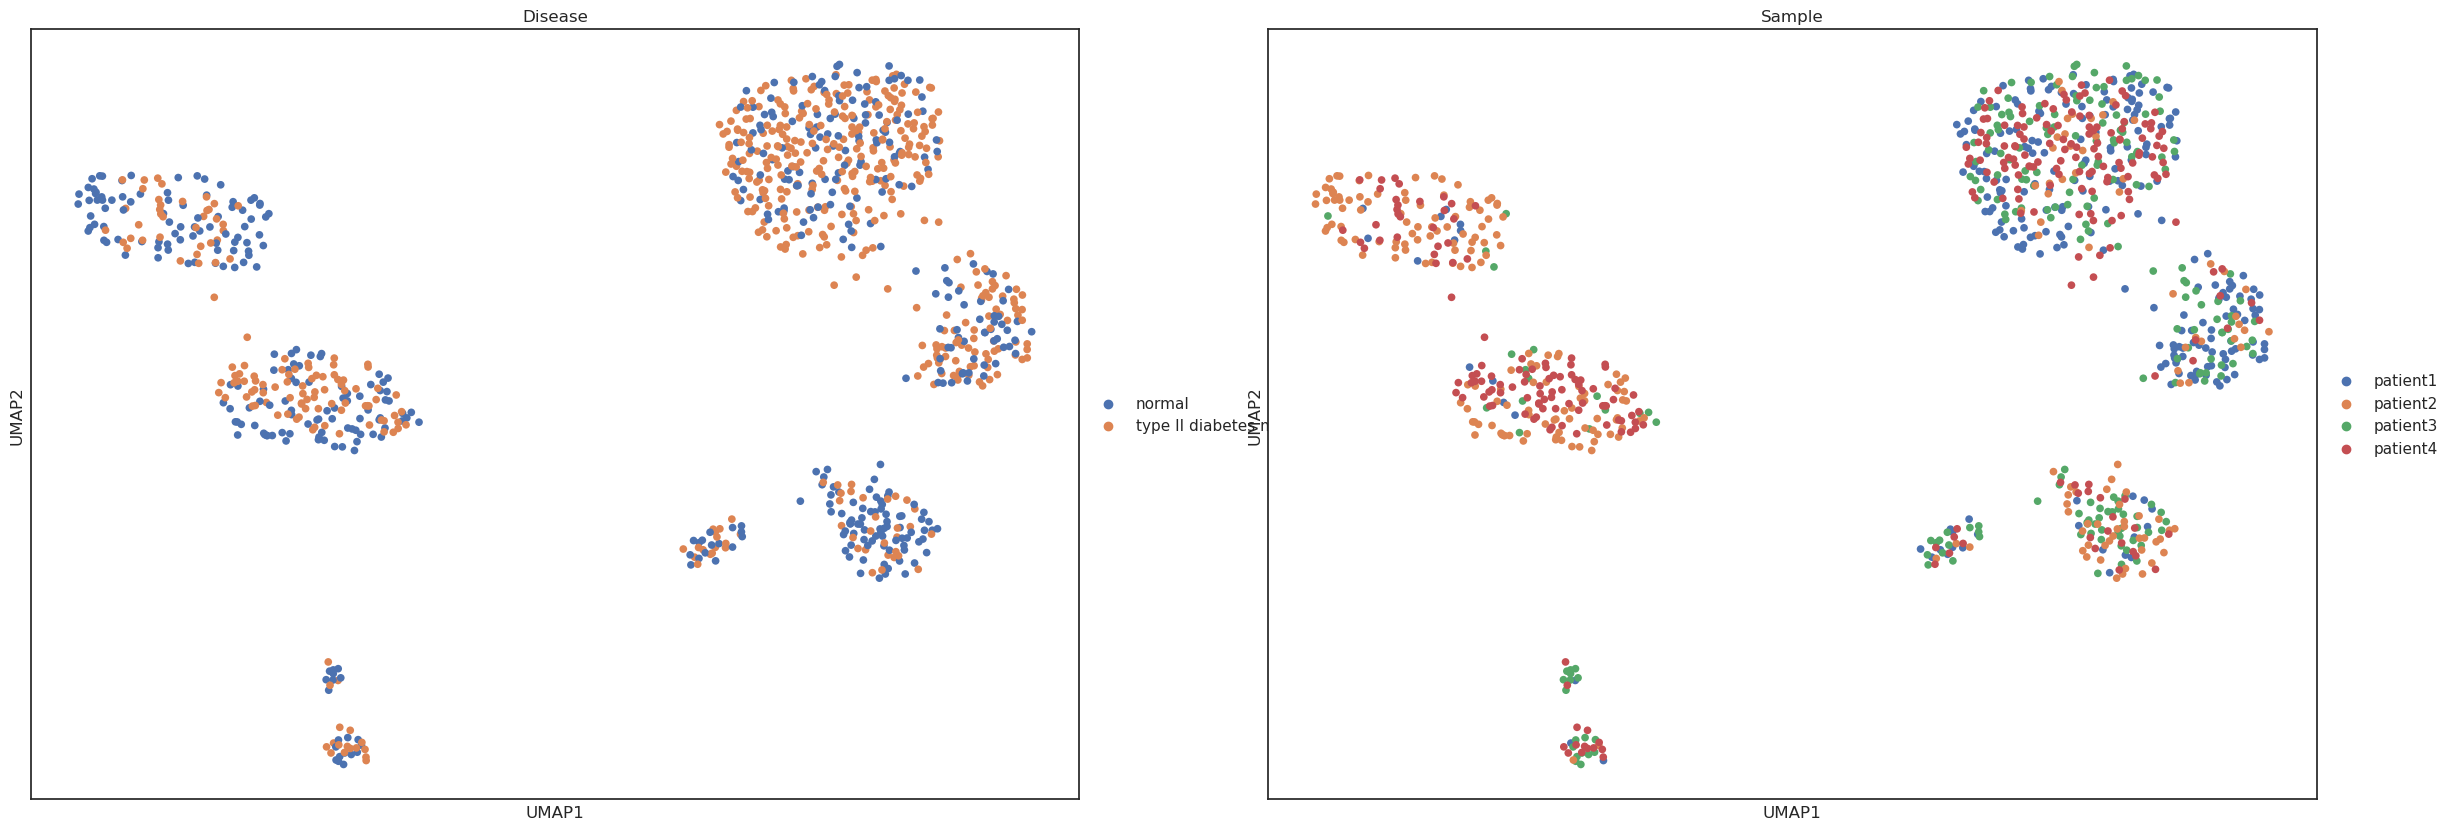

In [38]:
path = "data_path"
#apply clustering algorithms on training set
apply_louvain(sc_train_pp, 
              path + "/PCA.csv", 
              path + "/cluster_membership.csv",  
              plot = True, 
              store_pca_=False, 
              store_clustering=False)

Silhouette Score: 0.84093297


/home/mike/anaconda3/envs/eth_ml4g/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


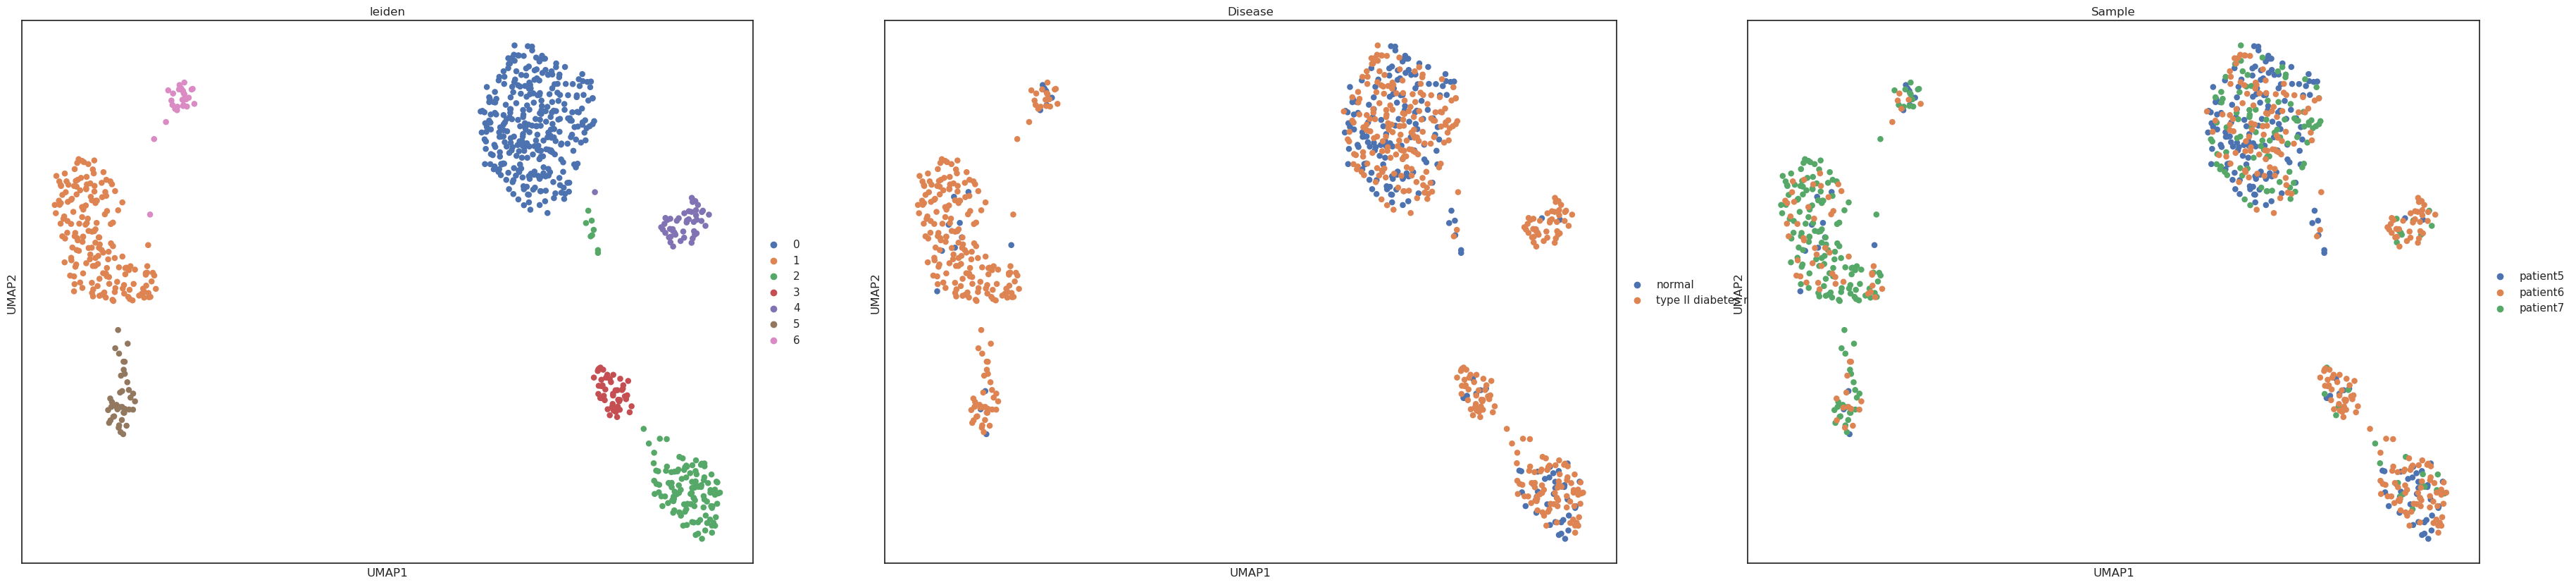

In [42]:
#apply clustering on test set
path_submission = path_cwd + '/ML4G_Project_2_Data/Vollenweider_Michael_Project2'
apply_louvain(sc_test_pp, 
              path_submission + "/PCA.csv", 
              path_submission + "/cluster_membership.csv",
              plot=True, 
              test=True)